In [1]:
from gui import GUI
import matplotlib.pyplot as plt
import ipywidgets as widgets

class Mbtree_GUI(GUI):
    def __init__(self, mbtree, size=0.15):
        self.mbtree = mbtree
        self.size = size
        self.width = 50
        self.height = 64
        self.selectednode = self.mbtree.root
        super().__init__()
        
    def create_widgets(self):
        self.output = widgets.Output()  
        self.left_button = self.create_button("←", 50)
        self.up_button = self.create_button("↑", 50)
        self.right_button = self.create_button("→", 50)
        self.down_button = self.create_button("↓", 50)
        self.help_button = self.create_button("？", 50)
        self.label = widgets.Label(value="", layout=widgets.Layout(width=f"50px"))
        
        with plt.ioff():
            self.fig = plt.figure(figsize=[self.width * self.size,
                                            self.height * self.size])
            self.ax = self.fig.add_axes([0, 0, 1, 1])
        self.fig.canvas.toolbar_visible = False
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False
        self.fig.canvas.resizable = False        
        
    def create_event_handler(self):
        def on_left_button_clicked(b=None):
            if self.selectednode.parent is not None:
                self.selectednode = self.selectednode.parent
                self.update_gui()
                
        def on_right_button_clicked(b=None):
            if self.selectednode.depth < 6 and len(self.selectednode.children) > 0:
                self.selectednode = self.selectednode.children[0]
                self.update_gui()

        def on_up_button_clicked(b=None):
            if self.selectednode.parent is not None:
                index = self.selectednode.parent.children.index(self.selectednode)
                if index > 0:
                    self.selectednode = self.selectednode.parent.children[index - 1]
                    self.update_gui()
                
        def on_down_button_clicked(b=None):
            if self.selectednode.parent is not None:
                index = self.selectednode.parent.children.index(self.selectednode)
                if self.selectednode.parent.children[-1] is not self.selectednode:
                    self.selectednode = self.selectednode.parent.children[index + 1]
                    self.update_gui()            
                    
        def on_help_button_clicked(b=None):
            self.output.clear_output()
            with self.output:
                print("""操作説明

    下記のキーとボタンで中心となるノードを移動できる。ただし、深さが 7 以上のノードへは移動できない
    ←、0 キー：親ノードへ移動
    ↑：一つ前の兄弟ノードへ移動
    ↓：一つ後の兄弟ノードへ移動
    →：先頭の子ノードへ移動

    テンキーで、対応するマスに着手が行われた子ノードへ移動する
    ノードの上でマウスを押すことでそのノードへ移動する
    """)
                            
        self.left_button.on_click(on_left_button_clicked)
        self.right_button.on_click(on_right_button_clicked)
        self.up_button.on_click(on_up_button_clicked)
        self.down_button.on_click(on_down_button_clicked)
        self.help_button.on_click(on_help_button_clicked)

        def on_key_press(event):
            keymap = {
                "left": on_left_button_clicked,
                "0": on_left_button_clicked,
                "right": on_right_button_clicked,
                "up": on_up_button_clicked,
                "down": on_down_button_clicked,
            }
            if event.key in keymap:
                keymap[event.key]()
            elif self.selectednode.depth < 6:
                try:
                    num = int(event.key) - 1
                    x = num % 3
                    y = 2 - (num // 3)
                    move = (x, y)
                    if move in self.selectednode.children_by_move:
                        self.selectednode = self.selectednode.children_by_move[move]
                        self.update_gui()
                except:
                    pass            
                
        def on_mouse_down(event):
            for rect, node in self.mbtree.nodes_by_rect.items():
                if node.depth <= 6 and rect.is_inside(event.xdata, event.ydata):
                    self.selectednode = node
                    self.update_gui()
                    break               
                
        # fig の画像イベントハンドラを結び付ける
        self.fig.canvas.mpl_connect("key_press_event", on_key_press)
        self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)    
            
    def display_widgets(self):
        hbox1 = widgets.HBox([self.label, self.up_button, self.label])
        hbox2 = widgets.HBox([self.left_button, self.label, self.right_button,
                            self.label, self.help_button])
        hbox3 = widgets.HBox([self.label, self.down_button, self.label])
        display(widgets.VBox([self.output, hbox1, hbox2, hbox3, self.fig.canvas]))   

    def update_gui(self):
        self.ax.clear()
        self.ax.set_xlim(-1, self.width - 1)
        self.ax.set_ylim(0, self.height)   
        self.ax.invert_yaxis()
        self.ax.axis("off")   
        
        if self.selectednode.depth <= 4:
            maxdepth = self.selectednode.depth + 1
        elif self.selectednode.depth == 5:
            maxdepth = 7
        else:
            maxdepth = 9
        self.mbtree.draw_subtree(self.selectednode, ax=self.ax, maxdepth=maxdepth)
        
        disabled = self.selectednode.parent is None
        self.set_button_status(self.left_button, disabled=disabled)
        disabled = self.selectednode.depth >= 6 or len(self.selectednode.children) == 0
        self.set_button_status(self.right_button, disabled=disabled)
        disabled = self.selectednode.parent is None or self.selectednode.parent.children.index(self.selectednode) == 0
        self.set_button_status(self.up_button, disabled=disabled)
        disabled = self.selectednode.parent is None or self.selectednode.parent.children[-1] is self.selectednode
        self.set_button_status(self.down_button, disabled=disabled)

In [2]:
from tree import Mbtree

def draw_subtree(self, centernode=None, selectednode=None, ax=None, size=0.25, lw=0.8, maxdepth=2):   
    self.nodes_by_rect = {}

    if centernode is None:
        centernode = self.root
    self.calc_node_height(maxdepth)
    width = 5 * (maxdepth + 1)
    height = centernode.height
    parent = centernode.parent
    if parent is not None:
        height += (len(parent.children) - 1) * 4
        parent.height = height
    if ax is None:
        fig, ax = plt.subplots(figsize=(width * size, height * size))
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)   
        ax.invert_yaxis()
        ax.axis("off")        
    
    nodelist = [centernode]
    depth = centernode.depth
    while len(nodelist) > 0 and depth <= maxdepth:        
        dy = 0
        if parent is not None:
            dy = parent.children.index(centernode) * 4
        childnodelist = []
        for node in nodelist:
            if node is None:
                dy += 4
                childnodelist.append(None)
            else:
                dx = 5 * node.depth
                emphasize = node is selectednode
                rect = node.draw_node(ax=ax, maxdepth=maxdepth, emphasize=emphasize, size=size, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = node
                dy += node.height
                if len(node.children) > 0:  
                    childnodelist += node.children
                else:
                    childnodelist.append(None)
        depth += 1
        nodelist = childnodelist
        
    if parent is not None:
        dy = 0
        for sibling in parent.children:
            if sibling is not centernode:
                sibling.height = 4
                dx = 5 * sibling.depth
                rect = sibling.draw_node(ax, maxdepth=sibling.depth, size=size, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = sibling
            dy += sibling.height
        dx = 5 * parent.depth
        rect = parent.draw_node(ax, maxdepth=maxdepth, size=size, lw=lw, dx=dx, dy=0)
        self.nodes_by_rect[rect] = parent
    
        node = parent
        while node.parent is not None:
            node = node.parent
            node.height = height
            dx = 5 * node.depth
            rect = node.draw_node(ax, maxdepth=node.depth, size=size, lw=lw, dx=dx, dy=0)
            self.nodes_by_rect[rect] = node
            
Mbtree.draw_subtree = draw_subtree

     9 depth 1 node created
    72 depth 2 node created
   504 depth 3 node created
  3024 depth 4 node created
 15120 depth 5 node created
 54720 depth 6 node created
148176 depth 7 node created
200448 depth 8 node created
127872 depth 9 node created
     0 depth 10 node created
total node num = 549946


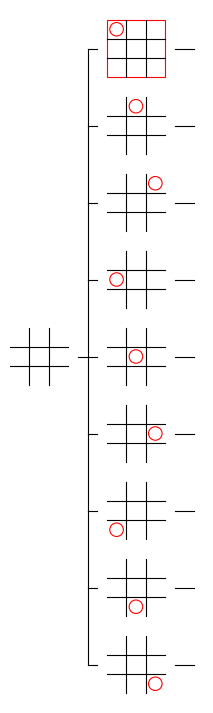

In [3]:
mbtree = Mbtree()
mbtree.draw_subtree(centernode=mbtree.root, 
                    selectednode=mbtree.nodelist_by_depth[1][0], maxdepth=1)

In [4]:
def create_event_handler(self):
    def on_left_button_clicked(b=None):
        if self.selectednode.parent is not None:
            self.selectednode = self.selectednode.parent
            self.update_gui()
            
    def on_right_button_clicked(b=None):
        if len(self.selectednode.children) > 0:
            self.selectednode = self.selectednode.children[0]
            self.update_gui()

    def on_up_button_clicked(b=None):
        if self.selectednode.parent is not None:
            index = self.selectednode.parent.children.index(self.selectednode)
            if index > 0:
                self.selectednode = self.selectednode.parent.children[index - 1]
                self.update_gui()
            
    def on_down_button_clicked(b=None):
        if self.selectednode.parent is not None:
            index = self.selectednode.parent.children.index(self.selectednode)
            if self.selectednode.parent.children[-1] is not self.selectednode:
                self.selectednode = self.selectednode.parent.children[index + 1]
                self.update_gui()            
                
    def on_help_button_clicked(b=None):
        self.output.clear_output()
        with self.output:
            print("""操作説明

下記のキーとボタンで中心となるノードを移動できる。
←、0 キー：親ノードへ移動
↑：一つ前の兄弟ノードへ移動
↓：一つ後の兄弟ノードへ移動
→：先頭の子ノードへ移動

テンキーで、対応するマスに着手が行われた子ノードへ移動する
ノードの上でマウスを押すことでそのノードへ移動する
""")
                        
    self.left_button.on_click(on_left_button_clicked)
    self.right_button.on_click(on_right_button_clicked)
    self.up_button.on_click(on_up_button_clicked)
    self.down_button.on_click(on_down_button_clicked)
    self.help_button.on_click(on_help_button_clicked)

    def on_key_press(event):
        keymap = {
            "left": on_left_button_clicked,
            "0": on_left_button_clicked,
            "right": on_right_button_clicked,
            "up": on_up_button_clicked,
            "down": on_down_button_clicked,
        }
        if event.key in keymap:
            keymap[event.key]()
        else:
            try:
                num = int(event.key) - 1
                x = num % 3
                y = 2 - (num // 3)
                move = (x, y)
                if move in self.selectednode.children_by_move:
                    self.selectednode = self.selectednode.children_by_move[move]
                    self.update_gui()
            except:
                pass            
            
    def on_mouse_down(event):
        for rect, node in self.mbtree.nodes_by_rect.items():
            if rect.is_inside(event.xdata, event.ydata):
                self.selectednode = node
                self.update_gui()
                break               
            
    # fig の画像イベントハンドラを結び付ける
    self.fig.canvas.mpl_connect("key_press_event", on_key_press)
    self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)    
    
Mbtree_GUI.create_event_handler = create_event_handler

In [5]:
mbtree_gui = Mbtree_GUI(mbtree)

In [6]:
def update_gui(self):
    self.ax.clear()
    self.ax.set_xlim(-1, self.width - 1)
    self.ax.set_ylim(0, self.height)   
    self.ax.invert_yaxis()
    self.ax.axis("off")   
    
    if self.selectednode.depth <= 4:
        maxdepth = self.selectednode.depth + 1
    elif self.selectednode.depth == 5:
        maxdepth = 7
    else:
        maxdepth = 9
    centernode = self.selectednode
    while centernode.depth > 6:
        centernode = centernode.parent
    self.mbtree.draw_subtree(centernode=centernode, selectednode=self.selectednode, ax=self.ax, maxdepth=maxdepth)
    
    disabled = self.selectednode.parent is None
    self.set_button_status(self.left_button, disabled=disabled)
    disabled = self.selectednode.depth >= 6 or len(self.selectednode.children) == 0
    self.set_button_status(self.right_button, disabled=disabled)
    disabled = self.selectednode.parent is None or self.selectednode.parent.children.index(self.selectednode) == 0
    self.set_button_status(self.up_button, disabled=disabled)
    disabled = self.selectednode.parent is None or self.selectednode.parent.children[-1] is self.selectednode
    self.set_button_status(self.down_button, disabled=disabled)
    
Mbtree_GUI.update_gui = update_gui

In [7]:
mbtree_gui = Mbtree_GUI(mbtree)

Play(value=1, max=10, min=1)

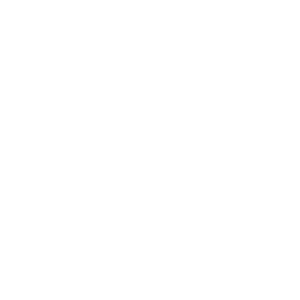

In [8]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(3, 3))
fig.canvas.header_visible = False
ax.axis("off")

play = widgets.Play(value=1, min=1, max=10, intervale=100)

def on_play_changed(changed):
    ax.clear()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis("off")
    
    value = changed["new"]    
    rect = patches.Rectangle(xy=(0, 0), width=value, height=value, fc="red")
    ax.add_artist(rect)
    
play.observe(on_play_changed, names="value")

display(play)    

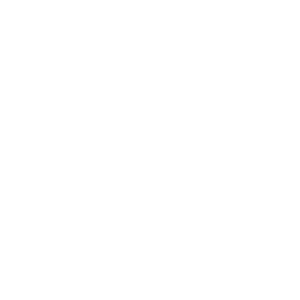

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))
fig.canvas.header_visible = False
ax.axis("off")

play = widgets.Play(value=1, min=1, max=10, interval=100)
slider = widgets.IntSlider(value=1, min=1, max=10)
widgets.jslink((play, "value"), (slider, "value"))

def on_play_changed(changed):
    ax.clear()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis("off")
    
    value = changed["new"]    
    rect = patches.Rectangle(xy=(0, 0), width=value, height=value, fc="red")
    ax.add_artist(rect)
    
play.observe(on_play_changed, names="value")

display(widgets.HBox([play, slider]))  

In [10]:
from marubatsu import Marubatsu

def create_tree_by_bf(self):
    # 深さ 0 のノードを、子ノードを作成するノードのリストに登録する
    nodelist = [self.root]
    depth = 0
    # 各深さのノードのリストを記録する変数を初期化する
    self.nodelist_by_depth = [ nodelist ]
    
    # 深さ depth のノードのリストが空になるまで繰り返し処理を行う
    while len(nodelist) > 0:
        childnodelist = [] 
        for node in nodelist:
            if node.mb.status == Marubatsu.PLAYING:
                node.calc_children()
                childnodelist += node.children
        self.nodelist_by_depth.append(childnodelist)
        nodelist = childnodelist
        depth += 1
        print(f"{len(nodelist):>6} depth {depth} node created")
        
    self.nodenum = 0
    self.nodelist = []
    for nodelist in self.nodelist_by_depth:
        self.nodenum += len(nodelist)
        self.nodelist += nodelist
    print(f"total node num = {self.nodenum}")
    
Mbtree.create_tree_by_bf = create_tree_by_bf

In [11]:
mbtree = Mbtree()
print(len(mbtree.nodelist))
print(mbtree.nodelist[0] is mbtree.root)

     9 depth 1 node created
    72 depth 2 node created
   504 depth 3 node created
  3024 depth 4 node created
 15120 depth 5 node created
 54720 depth 6 node created
148176 depth 7 node created
200448 depth 8 node created
127872 depth 9 node created
     0 depth 10 node created
total node num = 549946
549946
True


In [12]:
class Mbtree_Anim(GUI):
    def __init__(self, mbtree, size=0.15):
        self.mbtree = mbtree
        self.size = size
        self.width = 50
        self.height = 64
        super().__init__()
        
    def create_widgets(self):
        pass
    
    def display_widgets(self):
        pass
    
    def create_event_handler(self):
        pass
    
    def update_gui(self):
        pass

In [13]:
def create_widgets(self):
    self.play = widgets.Play(max=self.mbtree.nodenum - 1, interval=500)
    self.slider = widgets.IntSlider(max=self.mbtree.nodenum - 1, description="frame")
    widgets.jslink((self.play, "value"), (self.slider, "value"))
    
    with plt.ioff():
        self.fig = plt.figure(figsize=[self.width * self.size,
                                        self.height * self.size])
        self.ax = self.fig.add_axes([0, 0, 1, 1])
    self.fig.canvas.toolbar_visible = False
    self.fig.canvas.header_visible = False
    self.fig.canvas.footer_visible = False
    self.fig.canvas.resizable = False 
    
Mbtree_Anim.create_widgets = create_widgets

In [14]:
def display_widgets(self):
    hbox = widgets.HBox([self.play, self.slider])
    display(widgets.VBox([hbox, self.fig.canvas]))
    
Mbtree_Anim.display_widgets = display_widgets

In [15]:
def update_gui(self):
    self.ax.clear()
    self.ax.set_xlim(-1, self.width - 1)
    self.ax.set_ylim(0, self.height)   
    self.ax.invert_yaxis()
    self.ax.axis("off")   
    
    self.selectednode = self.mbtree.nodelist[self.play.value]
    self.centernode = self.selectednode
    if self.selectednode.depth <= 4:
        maxdepth = self.centernode.depth + 1
    elif self.centernode.depth == 5:
        maxdepth = 7
    else:
        maxdepth = 9
    self.mbtree.draw_subtree(centernode=self.centernode, selectednode=self.selectednode, ax=self.ax, maxdepth=maxdepth)
    
Mbtree_Anim.update_gui = update_gui

In [16]:
def create_event_handler(self):
    def on_play_changed(changed):
        self.update_gui()
        
    self.play.observe(on_play_changed, names="value")
    
Mbtree_Anim.create_event_handler = create_event_handler

In [17]:
mbtree_anim = Mbtree_Anim(mbtree)